# Traffic Analysis

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.gridspec as gridspec
import itertools
from sklearn.svm import SVC
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Importing Flow Table

In [81]:
df = pd.read_csv("check3.csv")

In [82]:
df.head()

,N_Packets,N_Bytes,Idle_age,Source,Destination,Switch,Traffic,Controller,Duration,time
0,1,42,18,10.0.0.2,10.0.0.6,1,low,6633,18.459,0.459
1,1,42,23,10.0.0.6,10.0.0.2,1,low,6633,23.477,0.477
2,1,42,18,10.0.0.6,10.0.0.2,1,low,6633,18.463,0.463
3,20,1960,4,10.0.0.2,10.0.0.6,1,high,6633,23.470,19.470
4,20,1960,4,10.0.0.6,10.0.0.2,1,high,6633,23.470,19.470


## Preprocessing

In [83]:
lb_make = LabelEncoder()
df['Source'] = lb_make.fit_transform(df['Source'])
df['Destination'] = lb_make.fit_transform(df['Destination'])
# df['Duration'] = lb_make.fit_transform(df['Duration'])
df.loc[df['Traffic']=='low','Traffic'] = 0
df.loc[df['Traffic']=='high','Traffic'] = 1


In [84]:
df.Controller.value_counts()

6633    244
6636    219
6635    214
6634    162
Name: Controller, dtype: int64

In [85]:
df.head()

,N_Packets,N_Bytes,Idle_age,Source,Destination,Switch,Traffic,Controller,Duration,time
0,1,42,18,0,7,1,0,6633,18.459,0.459
1,1,42,23,7,0,1,0,6633,23.477,0.477
2,1,42,18,7,0,1,0,6633,18.463,0.463
3,20,1960,4,0,7,1,1,6633,23.470,19.470
4,20,1960,4,7,0,1,1,6633,23.470,19.470


## Creating test set with 50 instances of each controller

In [86]:
test = df.reset_index(                  # need to keep the index as a column
    ).groupby('Controller'                    # split by "group"
    ).apply(lambda x: x.sample(50,random_state=200) # in each group, do the random split
    ).reset_index(drop=True              # index now is group id - reset it
    ).set_index('index')                 # reset the original index
train = df.drop(test.index) 

In [87]:
test.Controller.value_counts()

6636    50
6635    50
6634    50
6633    50
Name: Controller, dtype: int64

In [88]:
test.groupby('Controller')['Traffic'].value_counts(normalize=True)

Controller  Traffic
6633        0          0.50
            1          0.50
6634        0          0.68
            1          0.32
6635        0          0.62
            1          0.38
6636        0          0.56
            1          0.44
Name: Traffic, dtype: float64

## Data Analysis - Initial Traffic on the Controller 

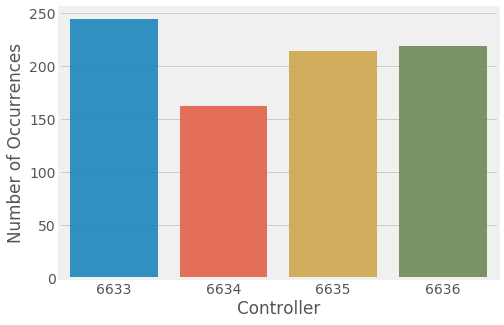

In [89]:
plt.figure(figsize=(7,5))

Controller_count = df['Controller'].value_counts()

#sns.set(style="darkgrid")
plt.style.use('fivethirtyeight')
sns.barplot(Controller_count.index, Controller_count.values, alpha=0.9)

#plt.title('Frequency Distribution of Switch')
plt.ylabel('Number of Occurrences')
plt.xlabel('Controller')
plt.show()

## Preparing Input data and spliting into training and testing

In [90]:
X = df.drop(['Traffic'], axis=1)
y =df['Traffic']

In [91]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train,y_train = train.drop(['Traffic'], axis=1),train['Traffic']
X_test,y_test = test.drop(['Traffic'], axis=1),test['Traffic']

## Feature selection based on importance 

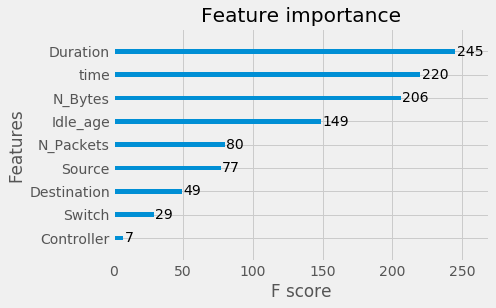

In [92]:
from xgboost import plot_importance
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
# plot feature importance
plot_importance(xgb)
plt.show()

## Generating modified train-test set

In [93]:
X_train_t = X_train.drop(['Controller','Switch','Destination'], axis=1)
X_test_t = X_test.drop(['Controller','Switch','Destination'], axis=1)


from sklearn.preprocessing import StandardScaler
cols = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [94]:
X_train.shape,X_test.shape,y_train.shape

((639, 9), (200, 9), (639,))

## Applying a sequential  model

In [102]:
model = Sequential()
model.add(Dense(6, activation = "relu", input_shape=(6, )))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(18, activation = "relu"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(18, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [103]:
history = model.fit(X_train_t, y_train, epochs=1000,verbose=1,validation_split=0.2,batch_size=40)
score = model.evaluate(X_test_t, y_test, verbose=0)

Train on 511 samples, validate on 128 samples
Epoch 1/1000
511/511 [==============================] - 0s 504us/step - loss: 140039305.6081 - accuracy: 0.4697 - val_loss: 1.6250 - val_accuracy: 0.4766
Epoch 2/1000
511/511 [==============================] - 0s 106us/step - loss: 52926714.1344 - accuracy: 0.4403 - val_loss: 5.6381 - val_accuracy: 0.5156
Epoch 3/1000
511/511 [==============================] - 0s 96us/step - loss: 30837768.6129 - accuracy: 0.4658 - val_loss: 8.6036 - val_accuracy: 0.5234
Epoch 4/1000
511/511 [==============================] - 0s 113us/step - loss: 19126853.1863 - accuracy: 0.4775 - val_loss: 10.4938 - val_accuracy: 0.5234
Epoch 5/1000
511/511 [==============================] - 0s 117us/step - loss: 23092.4154 - accuracy: 0.4736 - val_loss: 11.6066 - val_accuracy: 0.5234
Epoch 6/1000
511/511 [==============================] - 0s 111us/step - loss: 26166115.2009 - accuracy: 0.4755 - val_loss: 12.8333 - val_accuracy: 0.5234
Epoch 7/1000
511/511 [==============

511/511 [==============================] - 0s 100us/step - loss: 2014.2555 - accuracy: 0.6047 - val_loss: 12.5923 - val_accuracy: 0.6641
Epoch 56/1000
511/511 [==============================] - 0s 98us/step - loss: 52.2629 - accuracy: 0.6027 - val_loss: 12.5034 - val_accuracy: 0.6641
Epoch 57/1000
511/511 [==============================] - 0s 100us/step - loss: 57.0640 - accuracy: 0.5949 - val_loss: 12.4114 - val_accuracy: 0.6641
Epoch 58/1000
511/511 [==============================] - 0s 96us/step - loss: 71.7877 - accuracy: 0.5949 - val_loss: 12.3149 - val_accuracy: 0.6641
Epoch 59/1000
511/511 [==============================] - 0s 96us/step - loss: 108.4551 - accuracy: 0.6027 - val_loss: 12.2159 - val_accuracy: 0.6641
Epoch 60/1000
511/511 [==============================] - 0s 96us/step - loss: 73.7781 - accuracy: 0.5812 - val_loss: 12.1190 - val_accuracy: 0.6641
Epoch 61/1000
511/511 [==============================] - 0s 94us/step - loss: 55.6773 - accuracy: 0.5969 - val_loss: 12.0

511/511 [==============================] - 0s 100us/step - loss: 50.7245 - accuracy: 0.6438 - val_loss: 8.0799 - val_accuracy: 0.7188
Epoch 111/1000
511/511 [==============================] - 0s 96us/step - loss: 53.9914 - accuracy: 0.6321 - val_loss: 8.0165 - val_accuracy: 0.7188
Epoch 112/1000
511/511 [==============================] - 0s 92us/step - loss: 53.2637 - accuracy: 0.6380 - val_loss: 7.9561 - val_accuracy: 0.7188
Epoch 113/1000
511/511 [==============================] - 0s 92us/step - loss: 52.0540 - accuracy: 0.6380 - val_loss: 7.8966 - val_accuracy: 0.7188
Epoch 114/1000
511/511 [==============================] - 0s 92us/step - loss: 1690.0076 - accuracy: 0.6341 - val_loss: 7.8376 - val_accuracy: 0.7188
Epoch 115/1000
511/511 [==============================] - 0s 100us/step - loss: 5405.9292 - accuracy: 0.6262 - val_loss: 7.7772 - val_accuracy: 0.7188
Epoch 116/1000
511/511 [==============================] - 0s 94us/step - loss: 57.5394 - accuracy: 0.6536 - val_loss: 7.7

511/511 [==============================] - 0s 100us/step - loss: 741345.1090 - accuracy: 0.6673 - val_loss: 5.4717 - val_accuracy: 0.7578
Epoch 166/1000
511/511 [==============================] - 0s 102us/step - loss: 57.7795 - accuracy: 0.6791 - val_loss: 5.5332 - val_accuracy: 0.7578
Epoch 167/1000
511/511 [==============================] - 0s 94us/step - loss: 61.9259 - accuracy: 0.6575 - val_loss: 5.5197 - val_accuracy: 0.7578
Epoch 168/1000
511/511 [==============================] - 0s 100us/step - loss: 3622843.9807 - accuracy: 0.6556 - val_loss: 5.7176 - val_accuracy: 0.7578
Epoch 169/1000
511/511 [==============================] - 0s 96us/step - loss: 74.9014 - accuracy: 0.6575 - val_loss: 5.9742 - val_accuracy: 0.7578
Epoch 170/1000
511/511 [==============================] - 0s 92us/step - loss: 69.6279 - accuracy: 0.6732 - val_loss: 5.9949 - val_accuracy: 0.7578
Epoch 171/1000
511/511 [==============================] - 0s 92us/step - loss: 73.0098 - accuracy: 0.6517 - val_los

511/511 [==============================] - 0s 92us/step - loss: 70.2518 - accuracy: 0.6908 - val_loss: 3.6622 - val_accuracy: 0.7812
Epoch 221/1000
511/511 [==============================] - 0s 92us/step - loss: 70.8196 - accuracy: 0.6830 - val_loss: 3.6206 - val_accuracy: 0.7812
Epoch 222/1000
511/511 [==============================] - 0s 94us/step - loss: 68.2461 - accuracy: 0.6986 - val_loss: 3.5789 - val_accuracy: 0.7812
Epoch 223/1000
511/511 [==============================] - 0s 92us/step - loss: 70.4361 - accuracy: 0.7025 - val_loss: 3.5385 - val_accuracy: 0.7812
Epoch 224/1000
511/511 [==============================] - 0s 92us/step - loss: 201564.9162 - accuracy: 0.7006 - val_loss: 3.5598 - val_accuracy: 0.7812
Epoch 225/1000
511/511 [==============================] - 0s 96us/step - loss: 58.7761 - accuracy: 0.7045 - val_loss: 3.5442 - val_accuracy: 0.7891
Epoch 226/1000
511/511 [==============================] - 0s 102us/step - loss: 68.4727 - accuracy: 0.6928 - val_loss: 3.50

511/511 [==============================] - 0s 225us/step - loss: 62.7193 - accuracy: 0.7299 - val_loss: 1.8648 - val_accuracy: 0.8359
Epoch 276/1000
511/511 [==============================] - 0s 113us/step - loss: 58.5414 - accuracy: 0.7182 - val_loss: 1.8373 - val_accuracy: 0.8359
Epoch 277/1000
511/511 [==============================] - 0s 143us/step - loss: 49.2562 - accuracy: 0.7339 - val_loss: 1.8110 - val_accuracy: 0.8438
Epoch 278/1000
511/511 [==============================] - 0s 102us/step - loss: 69.3048 - accuracy: 0.7319 - val_loss: 1.7833 - val_accuracy: 0.8438
Epoch 279/1000
511/511 [==============================] - 0s 100us/step - loss: 60.4988 - accuracy: 0.7280 - val_loss: 1.7567 - val_accuracy: 0.8438
Epoch 280/1000
511/511 [==============================] - 0s 123us/step - loss: 61.7706 - accuracy: 0.7260 - val_loss: 1.7287 - val_accuracy: 0.8438
Epoch 281/1000
511/511 [==============================] - 0s 123us/step - loss: 68.0949 - accuracy: 0.7182 - val_loss: 1.

511/511 [==============================] - 0s 96us/step - loss: 66.5357 - accuracy: 0.7339 - val_loss: 0.7744 - val_accuracy: 0.9062
Epoch 331/1000
511/511 [==============================] - 0s 102us/step - loss: 54.2302 - accuracy: 0.7378 - val_loss: 0.7611 - val_accuracy: 0.9062
Epoch 332/1000
511/511 [==============================] - 0s 96us/step - loss: 55.3646 - accuracy: 0.7436 - val_loss: 0.7467 - val_accuracy: 0.9141
Epoch 333/1000
511/511 [==============================] - 0s 100us/step - loss: 62.4771 - accuracy: 0.7319 - val_loss: 0.7346 - val_accuracy: 0.9141
Epoch 334/1000
511/511 [==============================] - 0s 94us/step - loss: 68.9204 - accuracy: 0.7378 - val_loss: 0.7223 - val_accuracy: 0.9141
Epoch 335/1000
511/511 [==============================] - 0s 92us/step - loss: 55.7944 - accuracy: 0.7417 - val_loss: 0.7097 - val_accuracy: 0.9141
Epoch 336/1000
511/511 [==============================] - 0s 94us/step - loss: 55.0526 - accuracy: 0.7534 - val_loss: 0.6981 

511/511 [==============================] - 0s 100us/step - loss: 63.6974 - accuracy: 0.7671 - val_loss: 0.3214 - val_accuracy: 0.9531
Epoch 386/1000
511/511 [==============================] - 0s 98us/step - loss: 49.0282 - accuracy: 0.7652 - val_loss: 0.3175 - val_accuracy: 0.9531
Epoch 387/1000
511/511 [==============================] - 0s 96us/step - loss: 42.1762 - accuracy: 0.7573 - val_loss: 0.3139 - val_accuracy: 0.9531
Epoch 388/1000
511/511 [==============================] - 0s 94us/step - loss: 53.2415 - accuracy: 0.7534 - val_loss: 0.3103 - val_accuracy: 0.9531
Epoch 389/1000
511/511 [==============================] - 0s 102us/step - loss: 43.9963 - accuracy: 0.7769 - val_loss: 0.3071 - val_accuracy: 0.9688
Epoch 390/1000
511/511 [==============================] - 0s 94us/step - loss: 59.6631 - accuracy: 0.7593 - val_loss: 0.3039 - val_accuracy: 0.9688
Epoch 391/1000
511/511 [==============================] - 0s 96us/step - loss: 60.2717 - accuracy: 0.7573 - val_loss: 0.3007 

511/511 [==============================] - 0s 92us/step - loss: 53.4373 - accuracy: 0.7710 - val_loss: 0.2250 - val_accuracy: 0.9688
Epoch 441/1000
511/511 [==============================] - 0s 92us/step - loss: 48.7568 - accuracy: 0.7613 - val_loss: 0.2249 - val_accuracy: 0.9688
Epoch 442/1000
511/511 [==============================] - 0s 92us/step - loss: 58.2337 - accuracy: 0.7906 - val_loss: 0.2248 - val_accuracy: 0.9688
Epoch 443/1000
511/511 [==============================] - 0s 90us/step - loss: 49.2369 - accuracy: 0.7789 - val_loss: 0.2248 - val_accuracy: 0.9688
Epoch 444/1000
511/511 [==============================] - 0s 96us/step - loss: 49.2218 - accuracy: 0.7828 - val_loss: 0.2248 - val_accuracy: 0.9688
Epoch 445/1000
511/511 [==============================] - 0s 94us/step - loss: 53.4529 - accuracy: 0.7828 - val_loss: 0.2248 - val_accuracy: 0.9688
Epoch 446/1000
511/511 [==============================] - 0s 94us/step - loss: 55.7292 - accuracy: 0.7710 - val_loss: 0.2249 - 

511/511 [==============================] - 0s 94us/step - loss: 46.9104 - accuracy: 0.7789 - val_loss: 0.2482 - val_accuracy: 0.9766
Epoch 496/1000
511/511 [==============================] - 0s 94us/step - loss: 49.2118 - accuracy: 0.7906 - val_loss: 0.2492 - val_accuracy: 0.9766
Epoch 497/1000
511/511 [==============================] - 0s 94us/step - loss: 53.1014 - accuracy: 0.7984 - val_loss: 0.2499 - val_accuracy: 0.9766
Epoch 498/1000
511/511 [==============================] - 0s 104us/step - loss: 63.7336 - accuracy: 0.8004 - val_loss: 0.2509 - val_accuracy: 0.9766
Epoch 499/1000
511/511 [==============================] - 0s 94us/step - loss: 49.1209 - accuracy: 0.7769 - val_loss: 0.2518 - val_accuracy: 0.9766
Epoch 500/1000
511/511 [==============================] - 0s 94us/step - loss: 54.0555 - accuracy: 0.7906 - val_loss: 0.2527 - val_accuracy: 0.9766
Epoch 501/1000
511/511 [==============================] - 0s 92us/step - loss: 56.6899 - accuracy: 0.7750 - val_loss: 0.2537 -

511/511 [==============================] - 0s 113us/step - loss: 66.2636 - accuracy: 0.7808 - val_loss: 0.2489 - val_accuracy: 0.9688
Epoch 551/1000
511/511 [==============================] - 0s 100us/step - loss: 70.5497 - accuracy: 0.7828 - val_loss: 0.2496 - val_accuracy: 0.9688
Epoch 552/1000
511/511 [==============================] - 0s 106us/step - loss: 56.9034 - accuracy: 0.7867 - val_loss: 0.2503 - val_accuracy: 0.9688
Epoch 553/1000
511/511 [==============================] - 0s 108us/step - loss: 59.6105 - accuracy: 0.7750 - val_loss: 0.2510 - val_accuracy: 0.9688
Epoch 554/1000
511/511 [==============================] - 0s 100us/step - loss: 76.6737 - accuracy: 0.7906 - val_loss: 0.2518 - val_accuracy: 0.9766
Epoch 555/1000
511/511 [==============================] - 0s 109us/step - loss: 64.8932 - accuracy: 0.7789 - val_loss: 0.2527 - val_accuracy: 0.9766
Epoch 556/1000
511/511 [==============================] - 0s 106us/step - loss: 47.6453 - accuracy: 0.7808 - val_loss: 0.

511/511 [==============================] - 0s 96us/step - loss: 65.5412 - accuracy: 0.8043 - val_loss: 0.3117 - val_accuracy: 0.9766
Epoch 606/1000
511/511 [==============================] - 0s 94us/step - loss: 65.3170 - accuracy: 0.7945 - val_loss: 0.3123 - val_accuracy: 0.9766
Epoch 607/1000
511/511 [==============================] - 0s 94us/step - loss: 70.1132 - accuracy: 0.8082 - val_loss: 0.3127 - val_accuracy: 0.9766
Epoch 608/1000
511/511 [==============================] - 0s 92us/step - loss: 61.8672 - accuracy: 0.7886 - val_loss: 0.3129 - val_accuracy: 0.9766
Epoch 609/1000
511/511 [==============================] - 0s 98us/step - loss: 60.1222 - accuracy: 0.7984 - val_loss: 0.3129 - val_accuracy: 0.9766
Epoch 610/1000
511/511 [==============================] - 0s 94us/step - loss: 77.0832 - accuracy: 0.7906 - val_loss: 0.3130 - val_accuracy: 0.9766
Epoch 611/1000
511/511 [==============================] - 0s 92us/step - loss: 155236.2373 - accuracy: 0.7926 - val_loss: 0.310

511/511 [==============================] - 0s 94us/step - loss: 73.3243 - accuracy: 0.8102 - val_loss: 0.3162 - val_accuracy: 0.9766
Epoch 661/1000
511/511 [==============================] - 0s 90us/step - loss: 63.7105 - accuracy: 0.8023 - val_loss: 0.3165 - val_accuracy: 0.9766
Epoch 662/1000
511/511 [==============================] - 0s 98us/step - loss: 69.3852 - accuracy: 0.8004 - val_loss: 0.3169 - val_accuracy: 0.9766
Epoch 663/1000
511/511 [==============================] - 0s 98us/step - loss: 63.4826 - accuracy: 0.8121 - val_loss: 0.3172 - val_accuracy: 0.9766
Epoch 664/1000
511/511 [==============================] - 0s 90us/step - loss: 74.1900 - accuracy: 0.8082 - val_loss: 0.3176 - val_accuracy: 0.9766
Epoch 665/1000
511/511 [==============================] - 0s 94us/step - loss: 66.5036 - accuracy: 0.8023 - val_loss: 0.3180 - val_accuracy: 0.9766
Epoch 666/1000
511/511 [==============================] - 0s 102us/step - loss: 51.7087 - accuracy: 0.8121 - val_loss: 0.3184 -

511/511 [==============================] - 0s 92us/step - loss: 61.1423 - accuracy: 0.8063 - val_loss: 0.3359 - val_accuracy: 0.9766
Epoch 716/1000
511/511 [==============================] - 0s 92us/step - loss: 70.7419 - accuracy: 0.8180 - val_loss: 0.3362 - val_accuracy: 0.9766
Epoch 717/1000
511/511 [==============================] - 0s 94us/step - loss: 58.2540 - accuracy: 0.8082 - val_loss: 0.3366 - val_accuracy: 0.9766
Epoch 718/1000
511/511 [==============================] - 0s 98us/step - loss: 58.5690 - accuracy: 0.8180 - val_loss: 0.3369 - val_accuracy: 0.9766
Epoch 719/1000
511/511 [==============================] - 0s 88us/step - loss: 51.8007 - accuracy: 0.8297 - val_loss: 0.3372 - val_accuracy: 0.9766
Epoch 720/1000
511/511 [==============================] - 0s 92us/step - loss: 68.0982 - accuracy: 0.8278 - val_loss: 0.3375 - val_accuracy: 0.9766
Epoch 721/1000
511/511 [==============================] - 0s 94us/step - loss: 44.0419 - accuracy: 0.8180 - val_loss: 0.3380 - 

511/511 [==============================] - 0s 94us/step - loss: 74.2074 - accuracy: 0.8239 - val_loss: 0.3545 - val_accuracy: 0.9766
Epoch 771/1000
511/511 [==============================] - 0s 94us/step - loss: 74.3567 - accuracy: 0.8141 - val_loss: 0.3549 - val_accuracy: 0.9766
Epoch 772/1000
511/511 [==============================] - 0s 96us/step - loss: 68.3725 - accuracy: 0.8063 - val_loss: 0.3552 - val_accuracy: 0.9766
Epoch 773/1000
511/511 [==============================] - 0s 96us/step - loss: 59.3174 - accuracy: 0.8239 - val_loss: 0.3555 - val_accuracy: 0.9766
Epoch 774/1000
511/511 [==============================] - 0s 98us/step - loss: 64.1558 - accuracy: 0.8219 - val_loss: 0.3558 - val_accuracy: 0.9766
Epoch 775/1000
511/511 [==============================] - 0s 98us/step - loss: 69.0382 - accuracy: 0.8258 - val_loss: 0.3562 - val_accuracy: 0.9766
Epoch 776/1000
511/511 [==============================] - 0s 96us/step - loss: 66.9576 - accuracy: 0.8180 - val_loss: 0.3565 - 

511/511 [==============================] - 0s 96us/step - loss: 59.8847 - accuracy: 0.8337 - val_loss: 0.3716 - val_accuracy: 0.9766
Epoch 826/1000
511/511 [==============================] - 0s 96us/step - loss: 70.2629 - accuracy: 0.8121 - val_loss: 0.3718 - val_accuracy: 0.9766
Epoch 827/1000
511/511 [==============================] - 0s 100us/step - loss: 53.3082 - accuracy: 0.8200 - val_loss: 0.3721 - val_accuracy: 0.9766
Epoch 828/1000
511/511 [==============================] - 0s 94us/step - loss: 47.8100 - accuracy: 0.8200 - val_loss: 0.3724 - val_accuracy: 0.9766
Epoch 829/1000
511/511 [==============================] - 0s 92us/step - loss: 72.7036 - accuracy: 0.8121 - val_loss: 0.3726 - val_accuracy: 0.9766
Epoch 830/1000
511/511 [==============================] - 0s 94us/step - loss: 61.7198 - accuracy: 0.8297 - val_loss: 0.3729 - val_accuracy: 0.9766
Epoch 831/1000
511/511 [==============================] - 0s 92us/step - loss: 57.2840 - accuracy: 0.8258 - val_loss: 0.3733 -

511/511 [==============================] - 0s 94us/step - loss: 64.1196 - accuracy: 0.8317 - val_loss: 0.3873 - val_accuracy: 0.9766
Epoch 881/1000
511/511 [==============================] - 0s 94us/step - loss: 64.6229 - accuracy: 0.8415 - val_loss: 0.3876 - val_accuracy: 0.9766
Epoch 882/1000
511/511 [==============================] - 0s 92us/step - loss: 68.0971 - accuracy: 0.8415 - val_loss: 0.3879 - val_accuracy: 0.9766
Epoch 883/1000
511/511 [==============================] - 0s 92us/step - loss: 71.2567 - accuracy: 0.8258 - val_loss: 0.3882 - val_accuracy: 0.9766
Epoch 884/1000
511/511 [==============================] - 0s 94us/step - loss: 67.7313 - accuracy: 0.8395 - val_loss: 0.3885 - val_accuracy: 0.9766
Epoch 885/1000
511/511 [==============================] - 0s 92us/step - loss: 66.0542 - accuracy: 0.8337 - val_loss: 0.3887 - val_accuracy: 0.9766
Epoch 886/1000
511/511 [==============================] - 0s 96us/step - loss: 56.6930 - accuracy: 0.8258 - val_loss: 0.3890 - 

511/511 [==============================] - 0s 96us/step - loss: 52.7264 - accuracy: 0.8376 - val_loss: 0.4010 - val_accuracy: 0.9766
Epoch 936/1000
511/511 [==============================] - 0s 98us/step - loss: 75.1748 - accuracy: 0.8297 - val_loss: 0.4012 - val_accuracy: 0.9766
Epoch 937/1000
511/511 [==============================] - 0s 90us/step - loss: 51.4761 - accuracy: 0.8376 - val_loss: 0.4016 - val_accuracy: 0.9766
Epoch 938/1000
511/511 [==============================] - 0s 94us/step - loss: 60.2295 - accuracy: 0.8200 - val_loss: 0.4019 - val_accuracy: 0.9766
Epoch 939/1000
511/511 [==============================] - 0s 90us/step - loss: 65.0361 - accuracy: 0.8434 - val_loss: 0.4022 - val_accuracy: 0.9766
Epoch 940/1000
511/511 [==============================] - 0s 96us/step - loss: 60.0615 - accuracy: 0.8317 - val_loss: 0.4023 - val_accuracy: 0.9766
Epoch 941/1000
511/511 [==============================] - 0s 94us/step - loss: 66.6573 - accuracy: 0.8434 - val_loss: 0.4026 - 

511/511 [==============================] - 0s 92us/step - loss: 58.3576 - accuracy: 0.8297 - val_loss: 0.4136 - val_accuracy: 0.9766
Epoch 991/1000
511/511 [==============================] - 0s 98us/step - loss: 62.4185 - accuracy: 0.8493 - val_loss: 0.4137 - val_accuracy: 0.9766
Epoch 992/1000
511/511 [==============================] - 0s 94us/step - loss: 64.8539 - accuracy: 0.8317 - val_loss: 0.4138 - val_accuracy: 0.9766
Epoch 993/1000
511/511 [==============================] - 0s 92us/step - loss: 43.2042 - accuracy: 0.8278 - val_loss: 0.4140 - val_accuracy: 0.9766
Epoch 994/1000
511/511 [==============================] - 0s 98us/step - loss: 43.0258 - accuracy: 0.8337 - val_loss: 0.4142 - val_accuracy: 0.9766
Epoch 995/1000
511/511 [==============================] - 0s 94us/step - loss: 55.9538 - accuracy: 0.8278 - val_loss: 0.4144 - val_accuracy: 0.9766
Epoch 996/1000
511/511 [==============================] - 0s 100us/step - loss: 51.3063 - accuracy: 0.8317 - val_loss: 0.4146 -

## Test loss and accuracy

In [104]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 9.102776189898409
Test accuracy: 0.9100000262260437


## Plotting graphs - loss and accuracy

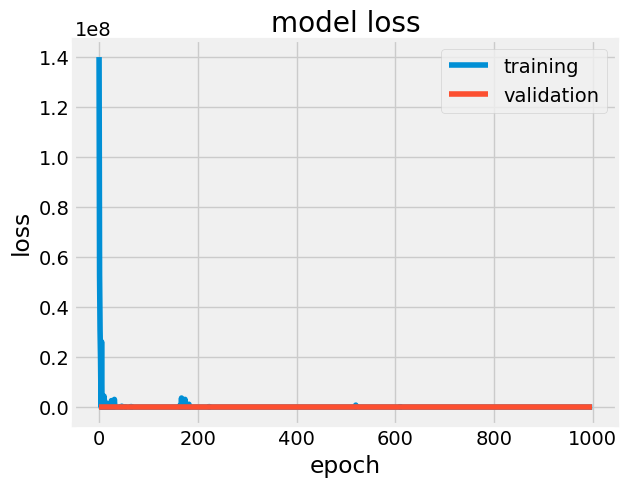

In [168]:
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [106]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

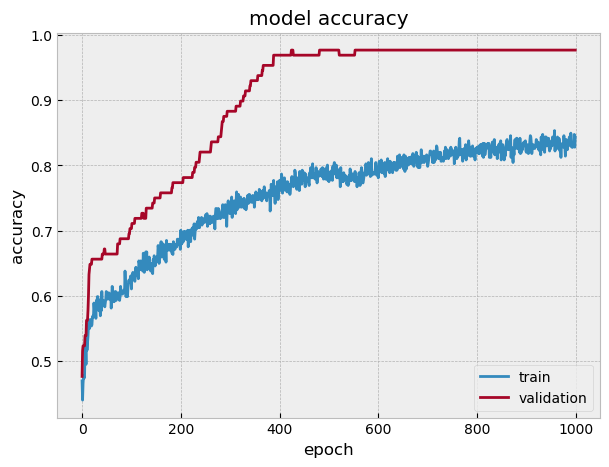

In [167]:
plt.figure(figsize=(7,5))
plt.style.use('bmh')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# Future Traffic Prediction - load on the controller - based on Neural Network

In [143]:
prediction = model.predict_classes(X_test_t)

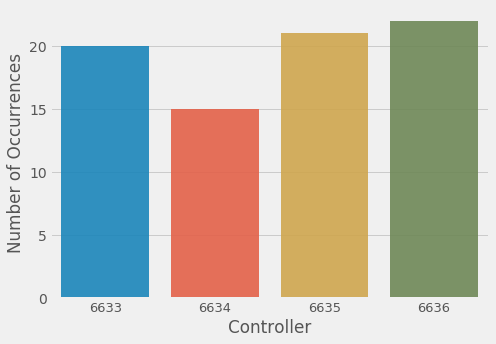

In [144]:
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')
Controller_count = pd.DataFrame(list(zip(X_test['Controller'],prediction[:,0]))).groupby(0)[1].value_counts()[:,1]
#sns.set(style="darkgrid")
ax = sns.barplot(Controller_count.index, Controller_count.values, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
#plt.title('Frequency Distribution of Switch')
plt.ylabel('Number of Occurrences')
plt.xlabel('Controller')
plt.show()

In [145]:
pd.DataFrame(list(zip(X_test['Controller'],prediction[:,0]))).groupby(0)[1].value_counts()[:,1]

0
6633    20
6634    15
6635    21
6636    22
Name: 1, dtype: int64

## Confusion Matrix 0 - low 1 - high

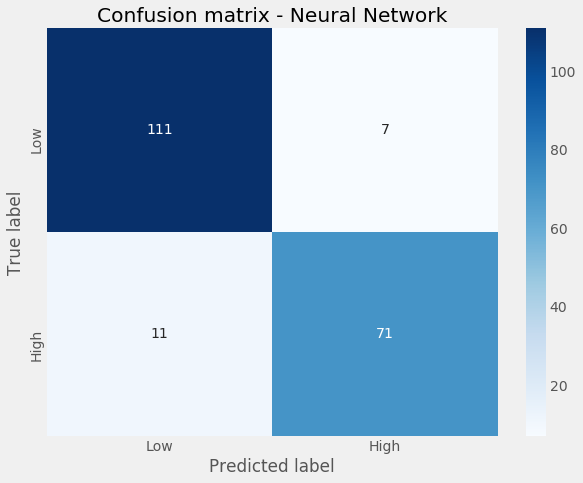

In [146]:
classes=['Low','High']
plt.figure(figsize=(9,7))
plt.title('Confusion matrix - Neural Network')
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test.astype(int),prediction[:,0]),annot=True,fmt='d',cmap="Blues") 
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [115]:
def create_model():
    model = Sequential()
    model.add(Dense(6, activation = "relu", input_shape=(6, )))
    model.add(Dropout(0.2, noise_shape=None, seed=None))
    model.add(Dense(18, activation = "relu"))
    model.add(Dropout(0.2, noise_shape=None, seed=None))
    model.add(Dense(18, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [116]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Performing 5-Fold Cross Validation and and comparing various algorithms

In [117]:
import warnings
warnings.filterwarnings("ignore")

xgb = XGBClassifier()
rf = RandomForestClassifier(n_estimators=200)
logreg= LogisticRegressionCV(solver='lbfgs', cv=10,max_iter=500)
nclf = KerasClassifier(create_model, epochs=1000,validation_split=0.2,batch_size=40,verbose=0)
svc = SVC(C = 1,random_state=20)

# est_AB = AdaBoostClassifier()
# score_AB=est_AB.fit(X_train,y_train).score(X_test,y_test)

# est_RF = RandomForestClassifier()
# score_RF=est_RF.fit(X_train,y_train).score(X_test,y_test)

# est_Ensemble = EnsembleVotingClassifier(estimators=[('XGB', xgb), ('RF', rf),('NN', nclf)],voting='hard')
est_Ensemble = EnsembleVoteClassifier(clfs=[xgb, rf, logreg,nclf], weights=[1, 1, 1, 0.8], voting='soft')

results = []
names = []
print("Accuracy and Standard deviation of various algorithms:")

for clf, label in zip([xgb, rf,logreg, svc,nclf, est_Ensemble], [
    'XGB Classifier',
    'Random Forest', 
    'Logistic Regression',
    'SVM',
    'Neural Network',
    'Ensemble']):
    
    scores = cross_val_score(clf, X_train_t, y_train, cv=5, scoring='accuracy')
    results.append(scores)
    names.append(label)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))    
    # boxplot algorithm comparison
# plt.rcParams['figure.figsize'] = [15, 8]              
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()
# score_Ensemble=est_Ensemble.fit(X_train,y_train).score(X_test,y_test)

Accuracy and Standard deviation of various algorithms:
Accuracy: 0.89 (+/- 0.07) [XGB Classifier]
Accuracy: 0.89 (+/- 0.07) [Random Forest]
Accuracy: 0.89 (+/- 0.08) [Logistic Regression]
Accuracy: 0.63 (+/- 0.01) [SVM]
Accuracy: 0.85 (+/- 0.07) [Neural Network]
Accuracy: 0.90 (+/- 0.06) [Ensemble]


## Boxplot -  Algorithm Comparison Chart

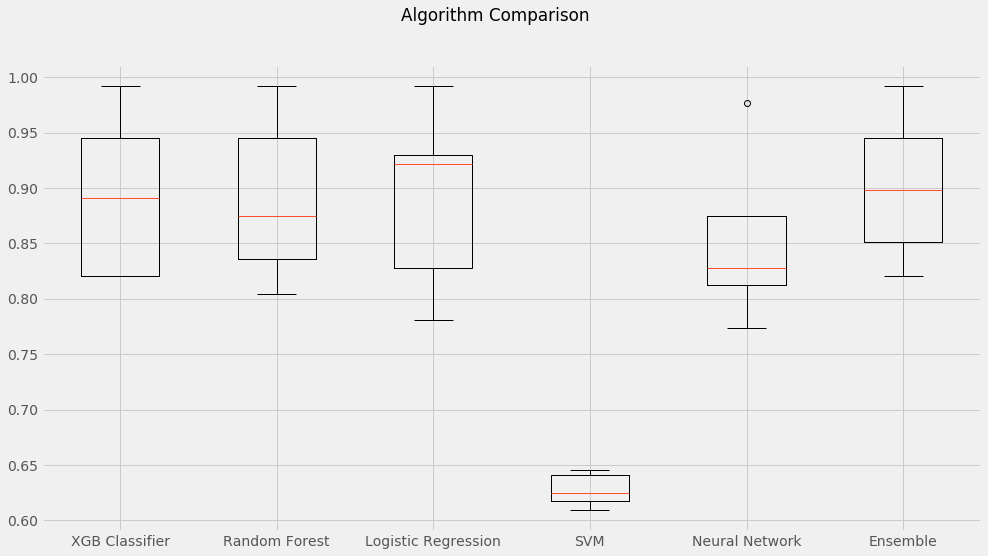

In [118]:
plt.rcParams['figure.figsize'] = [15, 8]              
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Plotting decision boundaries of various classifiers

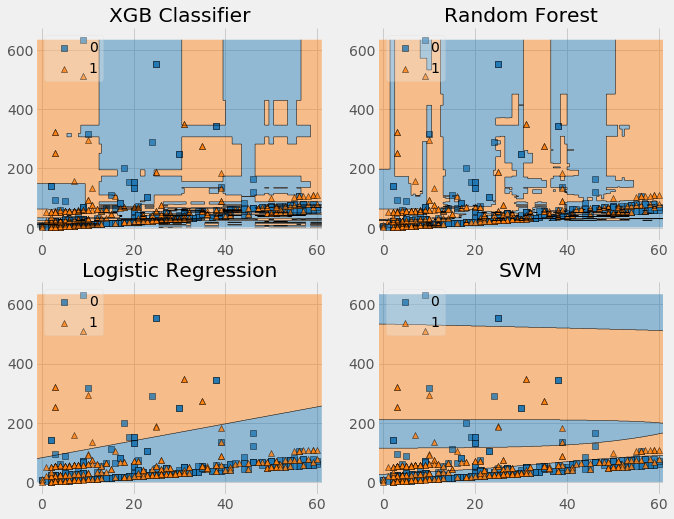

In [125]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for clf, label, grd  in zip([xgb, rf, logreg, svc], [
    'XGB Classifier',
    'Random Forest', 
    'Logistic Regression',
    'SVM'],
    itertools.product([0, 1], repeat=2)):
    
    clf.fit(X_train_t.values[:,[2,4]], y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_t.values[:,[2,4]], y=y_train.values,
                                clf=clf, legend=2)
    plt.title(label)

plt.show()

In [128]:
# est_Ensemble.fit(X_train_t,y_train)
# # est_Ensemble.predict(X_test_t)
# est_Ensemble.score(X_test_t,y_test)

0.925

In [127]:
# logreg= LogisticRegressionCV(solver='lbfgs', cv=10,max_iter=500)
# logreg.fit(X_train_t,y_train)
# logreg.score(X_test_t,y_test)

0.93

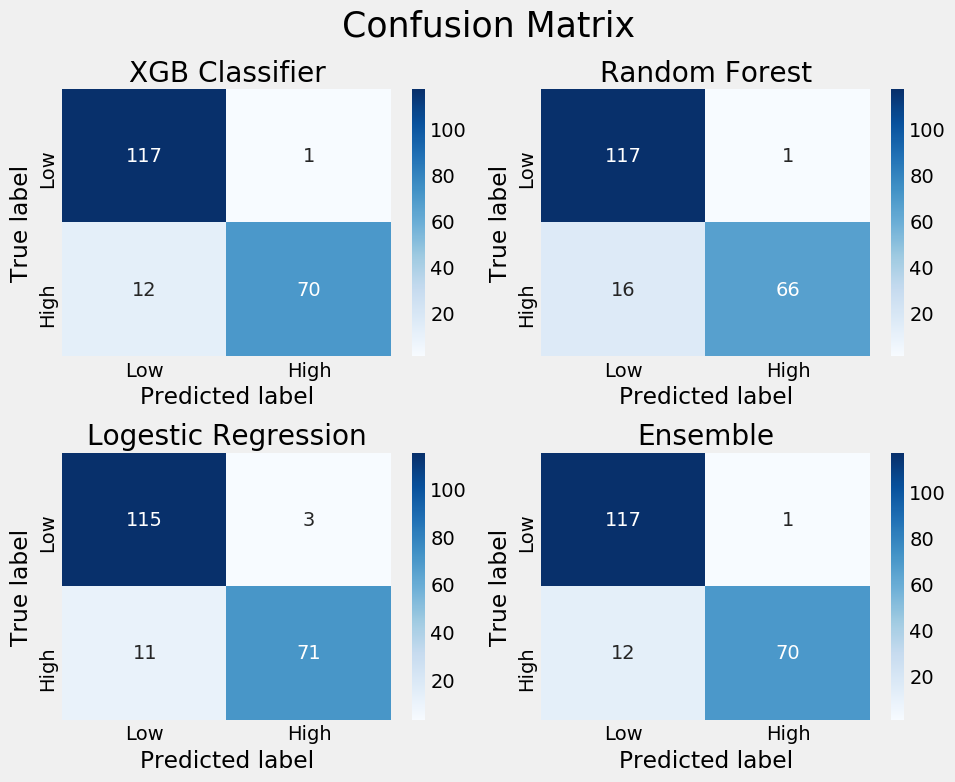

In [172]:
from sklearn.metrics import plot_confusion_matrix
classes=['Low','High']
plt.style.use('bmh')
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))
# plt.title('Confusion Matrix')
for clf, label, grd  in zip([xgb, rf, logreg, est_Ensemble], [
    'XGB Classifier',
    'Random Forest', 
    'Logestic Regression',
    'Ensemble'],
    itertools.product([0, 1], repeat=2)):
    clf.fit(X_train_t, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    plt.tight_layout()
    sns.heatmap(confusion_matrix(y_test,clf.predict(X_test_t)),annot=True,fmt='d',cmap="Blues") 
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(label)
plt.suptitle('Confusion Matrix',fontsize=25)
plt.subplots_adjust(top=0.88)
plt.show()

## Prediction using Ensemble Model

In [153]:
est_Ensemble.fit(X_train_t,y_train)

EnsembleVoteClassifier(clfs=[XGBClassifier(base_score=0.5, booster=None,
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=0,
                                           num_parallel_...
                             LogisticRegressionCV(Cs=10, class_weight=None,
                                                  cv=10, dual=False,
           

In [155]:
prediction = est_Ensemble.predict(X_test_t)

## Future Traffic Prediction - load on the controller - based on Ensemble Model

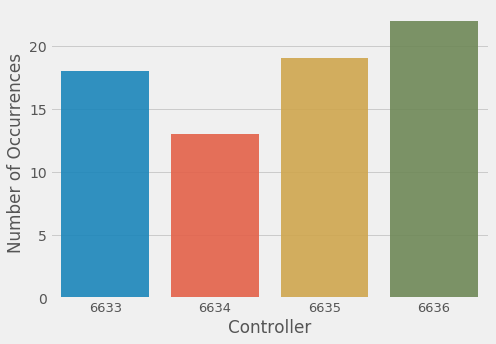

In [156]:
plt.figure(figsize=(7,5))
plt.style.use('fivethirtyeight')
Controller_count = pd.DataFrame(list(zip(X_test['Controller'],prediction))).groupby(0)[1].value_counts()[:,1]
#sns.set(style="darkgrid")
ax = sns.barplot(Controller_count.index, Controller_count.values, alpha=0.9)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
#plt.title('Frequency Distribution of Switch')
plt.ylabel('Number of Occurrences')
plt.xlabel('Controller')
plt.show()

In [157]:
pd.DataFrame(list(zip(X_test['Controller'],prediction))).groupby(0)[1].value_counts()[:,1]

0
6633    18
6634    13
6635    19
6636    22
Name: 1, dtype: int64

## Classification Report - Ensemble Model

In [160]:
print(classification_report(y_test,prediction,target_names=classes))

              precision    recall  f1-score   support

         Low       0.91      0.99      0.95       118
        High       0.99      0.87      0.92        82

    accuracy                           0.94       200
   macro avg       0.95      0.93      0.94       200
weighted avg       0.94      0.94      0.94       200

